### Project: Design a Neural Network that can classify healthy and non-healthy (with Tuberculosis (TB) manifestations) chest X-rays

#### Data: 
There are 80 number of normal chest x-ray images and 58 cases with manifestation of tuberculosis. The standard digital image database for Tuberculosis is created by the National Library of Medicine in collaboration with the Department of Health and Human Services, Montgomery County, Maryland, USA. The set contains data from X-rays collected under Montgomery County's Tuberculosis screening program.

#### Data Normalization:
Image data with labelled data, so it's a supervised problem. Extracting features: data normalization ([0,1] window)

#### Neural Network: 
Here in the model I have considered multiple hidden layers. Also used pre-trained model for training the dataset. Used different kernels, such as ReLU and sigmoid function. Also computed performance metrics like accuracy, AUC, sensitivity, sprecificity, precision, recall, f1-score, confusion matrix. 

#### Binary Becision: 
Tuberculosis versus Non-Tuberculosis

#### Train and test data: 
Here the ration of train and test data is 80:20 (train:test)

#### Cross Validation:
For cross validation, here used k-fold cross validation where k=5.

#### Import Libraries

In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import matplotlib.pyplot as plt
import glob as gb
import numpy as np

In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [4]:
from keras import backend as K

#### Setting the dataset path


In [5]:
#read DataSet
TrainImage="./Dataset/"

print(TrainImage)

./Dataset/


In [6]:
NormalImages = os.listdir(TrainImage + "/Normal")
TuberculosisImages = os.listdir(TrainImage + "/Tuberculosis")

#### Explore the Data

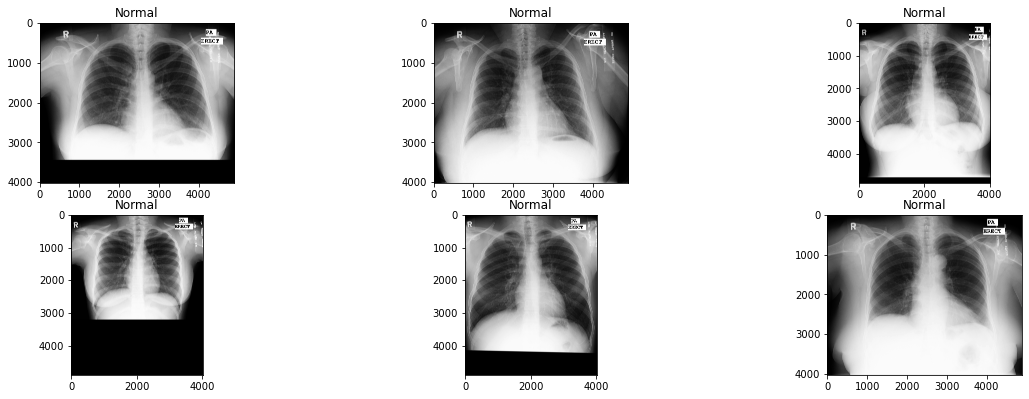

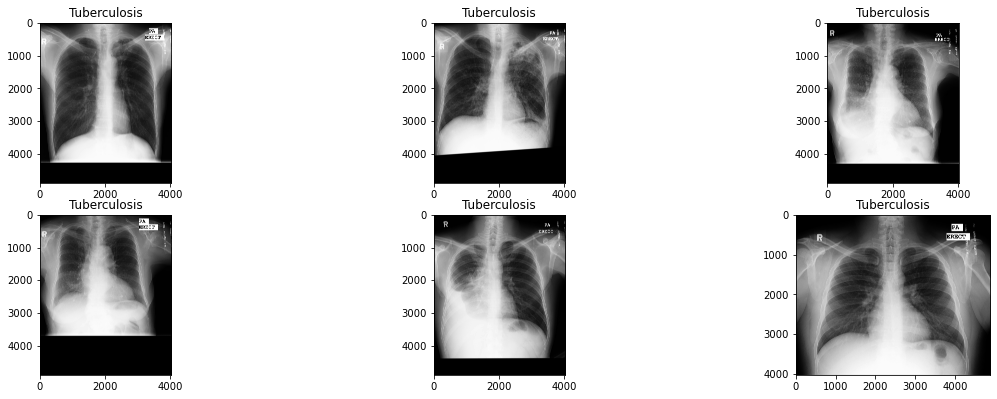

In [7]:
plt.show()
#plot Healthy
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/Normal",NormalImages[i])),cmap='gray')
    plt.title("Normal")

plt.show()
#plot Tuberculosis
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/Tuberculosis",TuberculosisImages[i])),cmap='gray')
    plt.title("Tuberculosis")

#### ImageDataGenerator (DataAugmentation )

In [8]:
Labels={'Tuberculosis':0,'Normal':1 }

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
               
#Test        
print(getCode('Tuberculosis'))
print(getLabel(1))

0
Normal


#### Load Data

In [9]:
#Reading image data
sizeImage=100  #to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.png' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y

In [10]:
#get train data
X, y = getData(TrainImage,sizeImage)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
print("X_train Shape        ",X_train.shape)

X_train Shape         (110, 100, 100, 3)


In [12]:
#Convert y_train to categorical
y_train=to_categorical(y_train,2)
print("y_train ",y_train.shape)


#Convert y_train to categorical
y_test=to_categorical(y_test,2)
print("y_test ",y_test.shape)

y_train  (110, 2)
y_test  (28, 2)


In [13]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

#### Build Model

In [14]:
#load weight
Network_Weight="./Weights/DenseNet-BC-121-32-no-top.h5"
print(Network_Weight)

./Weights/DenseNet-BC-121-32-no-top.h5


In [15]:
pre_trained_model = DenseNet121(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False

In [16]:
pre_trained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [17]:
def f1_score(X_train, y_train):
    def recall(X_train, y_train):
        true_positives = K.sum(K.round(K.clip(X_train * y_train, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(X_train, y_train):
        true_positives = K.sum(K.round(K.clip(X_train * y_train, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(X_train, y_train)
    recall = recall(X_train, y_train)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(64, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

x=tf.keras.layers.Dense(2 , activation='sigmoid')(x)   

model = Model(pre_trained_model.input, x) 

model.compile(optimizer='adam', loss="binary_crossentropy",
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='Sensitivity'), 
                       tf.keras.metrics.SpecificityAtSensitivity(0.5, name='Specificity'), f1_score, 
                       tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.TrueNegatives(name='tn'), 
                       tf.keras.metrics.FalseNegatives(name='fn'), tf.keras.metrics.FalsePositives(name='fp')])

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

#### K-fold Cross Validation

In [20]:
# K-fold Cross Validation model evaluation
num_folds = 5
fold_no = 1
epochs = 10
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=None)

In [21]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

filepath="tuberculosis.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [22]:
score_list = []

for train, test in kfold.split(X_train, y_train):
    
    train_generator =train_datagen.flow(
         X_train[train], y_train[train],
         batch_size= 20
    )

    test_generator =train_datagen.flow(
         X_train[test], y_train[test],
         batch_size= 20
    )  
    
    history = model.fit(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
             epochs=epochs)
    
    # Generate generalization metrics
    scores = model.evaluate(test_generator)
    score_list.append(scores)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]}; {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}; {model.metrics_names[6]} of {scores[6]}; {model.metrics_names[7]} of {scores[7]}; {model.metrics_names[8]} of {scores[8]}; {model.metrics_names[9]} of {scores[9]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

Epoch 1/10
2/2 [==============================] - 0s 20ms/step - loss: 0.6010 - accuracy: 0.6818 - auc: 0.7355 - precision: 0.6316 - Sensitivity: 0.5455 - Specificity: 0.7727 - f1_score: 0.7941 - tp: 12.0000 - tn: 15.0000 - fn: 10.0000 - fp: 7.0000
Score for fold 1: loss of 0.60097736120224; accuracy of 68.18181872367859%; auc of 0.7355371713638306; precision of 0.6315789222717285; Sensitivity of 0.5454545617103577; Specificity of 0.7727272510528564; f1_score of 0.7941176295280457; tp of 12.0; tn of 15.0; fn of 10.0
Epoch 1/10
2/2 [==============================] - 0s 20ms/step - loss: 0.6892 - accuracy: 0.5909 - auc: 0.6002 - precision: 0.6667 - Sensitivity: 0.3636 - Specificity: 0.7727 - f1_score: 0.8182 - tp: 8.0000 - tn: 18.0000 - fn: 14.0000 - fp: 4.0000
Score for fold 2: loss of 0.6892352104187012; accuracy of 59.090906381607056%; auc of 0.6002066135406494; precision of 0.6666666865348816; Sensitivity of 0.3636363744735718; Specificity of 0.7727272510528564; f1_score of 0.8181816

In [23]:
for s in score_list:
    print(s[1]*100)

68.18181872367859
59.090906381607056
63.63636255264282
59.090906381607056
50.0


#### Model Evaluation

In [24]:
test_generator =train_datagen.flow(
     X_test, y_test,
     batch_size= 20,
)

In [25]:
#Evaluate Model
model.evaluate(test_generator)

2/2 [==============================] - 0s 63ms/step - loss: 0.6846 - accuracy: 0.5714 - auc: 0.5861 - precision: 0.6000 - Sensitivity: 0.6429 - Specificity: 0.6786 - f1_score: 0.6477 - tp: 18.0000 - tn: 16.0000 - fn: 10.0000 - fp: 12.0000


[0.6846135258674622,
 0.5714285969734192,
 0.5860968828201294,
 0.6000000238418579,
 0.6428571343421936,
 0.6785714030265808,
 0.6477272510528564,
 18.0,
 16.0,
 10.0,
 12.0]

In [26]:
model.save('model_Tuberculosis.h5')

In [27]:
#prediction
pred = model.predict(test_generator)

In [29]:
y_test=[]
for i in range(5):
    y_test.extend(test_generator.__getitem__(0)[1])

In [31]:
y_test=np.array(y_test)

In [32]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

In [35]:
y_test

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

#### Confusion Matrix

In [39]:
#confusion_matrix to check in accuracy 
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(pred,y_test)
print(cm)

[[50  0]
 [ 0 50]]
